In [2]:
##Trying out Exercise LSTM NN for Text Classification using torch.nn module
##LSTM for Text Classification
##Reference: CoderzColumn Tutorial

##Prepare Dataset
##Load Dataset
##Build Vocabulary Of Tokens
##Create Data Loaders (Vectorize Text Data)
##Define Network
##Train Network
##Evaluate Network Performance
##Explain Network Predictions Using LIME Algorithm

import torch #root package
import pandas as pd
import numpy as np
import torchtext; torchtext.disable_torchtext_deprecation_warning()
##from torchtext import data
##from torchtext import datasets

print("PyTorch Version : {}".format(torch.__version__))

print("Torch Text Version : {}".format(torchtext.__version__))


PyTorch Version : 2.3.0+cu118
Torch Text Version : 0.18.0+cpu


In [3]:
from torchtext import data
from torchtext import datasets
from torch.utils.data import DataLoader

from torch import manual_seed
manual_seed(16)
from random import seed
seed(16)

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()

target_classes = ["World", "Sports", "Business", "Sci/Tec"]

##Error encountered to disable warning
##Error encountered to install packages torchtext, torchdata and portalocker
##install using pip install torchtext, torchdata, portalocker

##print(target_classes)
##train_dataset
##print(test_dataset)

C:\Python312\Lib\site-packages\torchdata\datapipes\__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [4]:
BATCH_SIZE = 64
LR = 0.0005

In [5]:
# Tokenizer

from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train, test = AG_NEWS('.', split=('train', 'test'))
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
vocab(tokenizer('My name is Kalyan and I am fascinated by Machine Learning'))


[1300, 951, 21, 0, 8, 282, 1913, 25935, 24, 2490, 4699]

In [6]:
##Build Vocabulary Of Tokens

from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def build_vocab(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocab([train_dataset, test_dataset]), specials=["<UNK>"])
vocab.set_default_index(vocab["<UNK>"])

len(vocab.get_itos())

98635

In [7]:
##Create Data Loaders (Vectorize Text Data)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

vectorizer = CountVectorizer(vocabulary=vocab.get_itos(), tokenizer=tokenizer)

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = vectorizer.transform(X).todense()
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y) - 1 ## We have deducted 1 from target names to get them in range [0,1,2,3] from [1,2,3,4]

train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=256, collate_fn=vectorize_batch)
test_loader  = DataLoader(test_dataset, batch_size=256, collate_fn=vectorize_batch)

In [8]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([256, 98635]) torch.Size([256])


In [9]:
##Define Network

from torch import nn
from torch.nn import functional as F

class TextClassifier(nn.Module):
    def __init__(self):
        super(TextClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(len(vocab), 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 4),
            #nn.ReLU(),

            #nn.Linear(64, 4),
        )

    def forward(self, X_batch):
        return self.seq(X_batch)



In [10]:
text_classifier = TextClassifier()
for X, Y in train_loader:
    Y_preds = text_classifier(X)
    print(Y_preds.shape)
    break

torch.Size([256, 4])


In [11]:
##Train Network

from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))
        

In [12]:
def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader)


In [13]:
from torch.optim import Adam

##epochs = 8
epochs = 2
## reduce number of epochs for convenience, to reduce runtime, as program takes too long to run in computer
## Observation: Loss reduces with every epoch iteration
##100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [05:48<00:00,  1.34it/s]
##Train Loss : 0.779
##Valid Loss : 0.357
##Valid Acc  : 0.899
##100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [25:12<00:00,  3.22s/it]
##Train Loss : 0.283
##Valid Loss : 0.277
##Valid Acc  : 0.913
##100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [05:16<00:00,  1.48it/s]
##Train Loss : 0.210
##Valid Loss : 0.255
##Valid Acc  : 0.917
##100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [03:59<00:00,  1.96it/s]
##Train Loss : 0.168
##Valid Loss : 0.246
##Valid Acc  : 0.917
##100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [04:05<00:00,  1.91it/s]
##Train Loss : 0.137
##Valid Loss : 0.245
##Valid Acc  : 0.918
##100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [04:29<00:00,  1.74it/s]
##Train Loss : 0.113
##Valid Loss : 0.248
##Valid Acc  : 0.918
##100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [04:06<00:00,  1.90it/s]
##Train Loss : 0.093
##Valid Loss : 0.256
##Valid Acc  : 0.918
##100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [04:40<00:00,  1.67it/s]
##Train Loss : 0.077
##Valid Loss : 0.267
##Valid Acc  : 0.917



learning_rate = 1e-4

loss_fn = nn.CrossEntropyLoss()
text_classifier = TextClassifier()
optimizer = Adam(text_classifier.parameters(), lr=learning_rate)

TrainModel(text_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:18<00:00,  3.38it/s]


Train Loss : 0.779
Valid Loss : 0.357
Valid Acc  : 0.899


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:38<00:00,  2.96it/s]


Train Loss : 0.283
Valid Loss : 0.277
Valid Acc  : 0.913


In [14]:
##Evaluate Network Performance

def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(text_classifier, test_loader)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.9134210526315789

Classification Report : 
              precision    recall  f1-score   support

       World       0.93      0.91      0.92      1900
      Sports       0.95      0.98      0.97      1900
    Business       0.87      0.89      0.88      1900
     Sci/Tec       0.90      0.87      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600


Confusion Matrix : 
[[1729   56   70   45]
 [  12 1866   19    3]
 [  63   15 1696  126]
 [  60   19  170 1651]]


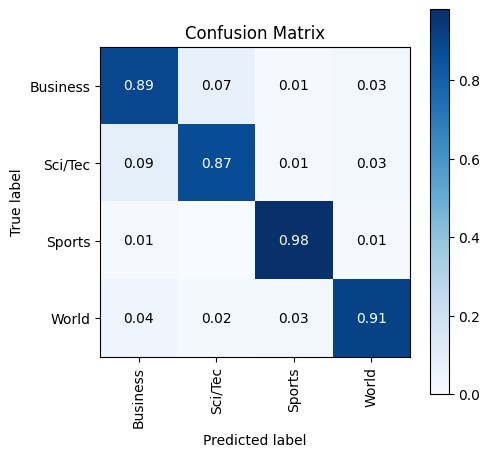

In [15]:
import matplotlib.pyplot as plt
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Blues",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

In [16]:
##Explain Network Predictions using LIME

from lime import lime_text

explainer = lime_text.LimeTextExplainer(class_names=target_classes, verbose=True)


In [17]:
import numpy as np

## Retrieve test documents.
train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
X_test_text, Y_test = [], []
for Y, X in test_dataset:
    X_test_text.append(X)
    Y_test.append(Y-1)

## Function to make prediction from text data
def make_predictions(X_batch_text):
    X_batch_vect = vectorizer.transform(X_batch_text).todense()
    logits = text_classifier(torch.tensor(X_batch_vect, dtype=torch.float32))
    preds = F.softmax(logits, dim=-1)
    return preds.detach().numpy()

## Randomly select test example for explanation
rng = np.random.RandomState(1)
idx = rng.randint(1, len(X_test_text))

X_batch_vect = vectorizer.transform(X_test_text[idx:idx+1]).todense()
logits = text_classifier(torch.tensor(X_batch_vect, dtype=torch.float32))
preds = F.softmax(logits, dim=-1)

print("Prediction : ", target_classes[preds.argmax(axis=-1)[0]])
print("Actual :     ", target_classes[Y_test[idx]])

Prediction :  Business
Actual :      Business


In [18]:
explanation = explainer.explain_instance(X_test_text[idx],
                                         classifier_fn=make_predictions,
                                         labels=Y_test[idx:idx+1], num_features=15)
explanation.show_in_notebook()

MemoryError: Unable to allocate 3.67 GiB for an array with shape (5000, 98635) and data type int64